# Imports and Data Preparation

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

import keras

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Layer, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, CSVLogger, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

I0000 00:00:1760905355.396962   26996 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1760905355.465591   26996 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760905356.544556   26996 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
W0000 00:00:1760905360.402939   26996 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries co

In [2]:
tf.__version__

'2.21.0-dev20251016'

In [3]:
tf.random.set_seed(42)

# Data Processing

In [4]:
ds_train, ds_val, ds_test = tfds.load("malaria", split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                      as_supervised=True, data_dir="data/")

W0000 00:00:1760905361.441194   26996 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760905361.578583   26996 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5783 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 12.0a


I0000 00:00:1760905361.730412   27205 tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1760905362.394956   26996 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


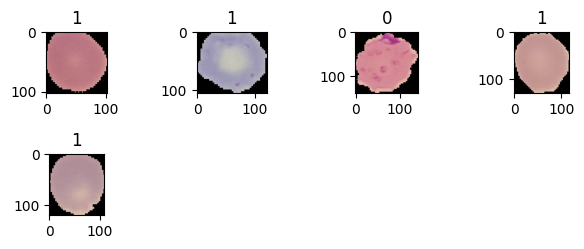

In [5]:
for i, (image, label) in enumerate(ds_train.take(5)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(label.numpy())
    plt.tight_layout()

In [6]:
IMAGE_SIZE = 224

In [7]:
def resizing(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255
    return image, label

In [8]:
def augmentation(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    image = image / 255.0  # Normalize first

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.clip_by_value(image, 0.0, 1.0)  # Ensure valid pixel values

    return image, label

In [9]:
ds_train_resized = ds_train.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_resized = ds_val.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_resized = ds_test.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
BATCH_SIZE = 32

ds_train_processed = ds_train_resized.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val_processed = ds_val_resized.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_processed = ds_test_resized.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
def delete_models():
    import os

    folder = "models"

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # delete file or symlink
            elif os.path.isdir(file_path):
                import shutil
                shutil.rmtree(file_path)  # delete subdirectory
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Model Subclassing

In [16]:
@keras.saving.register_keras_serializable()
class FeatureExtractorLayer(Layer):
    def __init__(self):
        super().__init__()

        self.reg_param = 0.01

        # First block
        self.conv_1 = Conv2D(16, 3, activation="relu", padding="same", kernel_regularizer=l2(self.reg_param))
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D()

        # Second block
        self.conv_2 = Conv2D(32, 3, activation="relu", padding="same", kernel_regularizer=l2(self.reg_param))
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D()

        # Third block
        self.conv_3 = Conv2D(64, 3, activation="relu", padding="same", kernel_regularizer=l2(self.reg_param))
        self.batch_3 = BatchNormalization()
        self.pool_3 = MaxPool2D()

        # Fourth block
        self.conv_4 = Conv2D(128, 3, activation="relu", padding="same", kernel_regularizer=l2(self.reg_param))
        self.batch_4 = BatchNormalization()
        self.pool_4 = MaxPool2D()

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        x = self.conv_3(x)
        x = self.batch_3(x)
        x = self.pool_3(x)

        x = self.conv_4(x)
        x = self.batch_4(x)
        x = self.pool_4(x)

        return x

In [17]:
@keras.saving.register_keras_serializable()
class DenseBlock(Layer):
    def __init__(self):
        super().__init__()

        self.global_pool = GlobalMaxPooling2D()
        self.dense_1 = Dense(128, activation="relu")
        self.dense_2 = Dense(64, activation="relu")
        self.dropout = Dropout(0.4)
        self.output_layer = Dense(1, activation="sigmoid")


    def  call(self, inputs, training=False):
        x = self.global_pool(inputs)

        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dropout(x, training=training)

        func_output = self.output_layer(x)

        return func_output

In [18]:
@keras.saving.register_keras_serializable()
class LenetModel(Model):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractorLayer()

        self.dense_block = DenseBlock()

    def call(self, inputs, training=False):
        x = self.feature_extractor(inputs)

        func_output = self.dense_block(x, training=training)

        return func_output

# Model Compiling

In [19]:
model = LenetModel()

metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics = metrics)

# Callbacks

In [20]:
csv_callback = CSVLogger(
    'logs/logs.csv', separator=',', append=False,
)

In [21]:
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

In [22]:
def schedule(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(schedule, verbose=1)

In [23]:
checkpoint_callback = ModelCheckpoint(
    'models/model_epoch{epoch}_valacc{val_accuracy:.02f}.keras',
    monitor='val_accuracy',
    save_best_only=False,
    mode='auto',
    verbose=1,
    save_weights_only=False
)

In [24]:
callbacks = [es_callback, lr_scheduler, csv_callback, checkpoint_callback]

# Model Training

In [32]:
delete_models()
history = model.fit(ds_train_processed, validation_data=ds_val_processed, epochs=10, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0006065306952223182.
Epoch 1/10
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9569 - auc: 0.9795 - fn: 201.1846 - fp: 293.4273 - loss: 0.1849 - precision: 0.9493 - recall: 0.9662 - tn: 5191.9448 - tp: 5337.4433
Epoch 1: saving model to models/model_epoch1_valacc0.91.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.9541 - auc: 0.9790 - fn: 412.0000 - fp: 599.0000 - loss: 0.1894 - precision: 0.9467 - recall: 0.9627 - tn: 10400.0000 - tp: 10635.0000 - val_accuracy: 0.9129 - val_auc: 0.9831 - val_fn: 11.0000 - val_fp: 229.0000 - val_loss: 0.3008 - val_precision: 0.8537 - val_recall: 0.9918 - val_tn: 1180.0000 - val_tp: 1336.0000 - learning_rate: 6.0653e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0006065306952223182.
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9554 - auc: 0.9792 - fn: 204.8592 - fp: 300.9318 - loss: 0.1874 - precision: 0.9482 - recall: 0.9642 - tn: 51

# Model Evaluation

In [26]:
model.evaluate(ds_test_processed)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9503 - auc: 0.9783 - fn: 30.0000 - fp: 107.0000 - loss: 0.2003 - precision: 0.9268 - recall: 0.9783 - tn: 1264.0000 - tp: 1355.0000


[0.20025718212127686,
 1355.0,
 107.0,
 1264.0,
 30.0,
 0.9502902626991272,
 0.9268125891685486,
 0.9783393740653992,
 0.9782702922821045]

# Visualizing Confusion Matrix

In [33]:
model.save("models/model_current_session.keras")

In [28]:
labels = []
inp = []

for x, y in ds_test_processed.as_numpy_iterator():
    labels.extend(y)
    inp.extend(x)

np.array(inp).shape

I0000 00:00:1760905786.780668   26996 local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(2756, 224, 224, 3)

In [29]:
# Generate predictions for the entire test dataset
predicted_probabilities = model.predict(ds_test_processed)
# Flatten the predicted probabilities to match the labels list structure
predicted = predicted_probabilities.flatten()

predicted

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


array([0.94915444, 0.9526105 , 0.01320264, ..., 0.9616225 , 0.9483294 ,
       0.00262703], shape=(2756,), dtype=float32)

In [30]:
predicted.shape

(2756,)

In [31]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
cm

array([[1264,  107],
       [  30, 1355]])